# Sommaire 
#### Que veut dire la stabilité temporelle de la segmentation¶? 
#### Créer des dataframes mensuels 
#### Tester le modèle en fonction d'une période donnée
#### Prediction de labels_true et  labels_pred  
#### Calcul de ARI mensuel
#### Conclusion

In [1]:
#Importer les librairies

import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from time import time

import datetime
from datetime import datetime as dt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import adjusted_rand_score

from scipy.spatial.distance import cdist  

## Que veut dire la stabilité temporelle de la segmentation¶? 

- Afin d'établir le contrat de maintenance de l'algorithme de segmentation des clients, il faut tester sa stabilité dans le temps et voir, par exemple, à quel moment les clients changent de Cluster.

- L’objectif est de déterminer au bout de combien de temps le modèle de clustering entraîné initialement proposé (donc « fit ») devient obsolète nécessitant d’entraîner un nouveau modèle de clustering

In [2]:
df = pd.read_csv(r"C:\Users\faeze\OneDrive\Documents\OC data science\PROJECT\Projet5\rfm_df.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92746 entries, 0 to 92745
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            92746 non-null  int64  
 1   customer_unique_id    92746 non-null  object 
 2   total_montant         92746 non-null  float64
 3   delivery_days         92746 non-null  float64
 4   payment_installments  92746 non-null  float64
 5   month                 92746 non-null  int64  
 6   year                  92746 non-null  int64  
 7   month_year            92746 non-null  object 
 8   frequence             92746 non-null  int64  
 9   Note_Moy_Com          92746 non-null  float64
 10  recence               92746 non-null  int64  
 11  nbr_commande          92746 non-null  int64  
 12  Nbr_produits          92746 non-null  int64  
 13  panier_moyen          92746 non-null  float64
dtypes: float64(5), int64(7), object(2)
memory usage: 9.9+ MB


### Créer les données mensuelles 

In [5]:
dff = []

for i in range(0,10):
    dff.append(pd.DataFrame())

dff[0] = df[df['year'] == 2017][['frequence','recence','panier_moyen']]

for i in range(1, 10):
    dff[i] = df[(df['month_year'] == '2018-0%s' %i)][['frequence', 'recence','panier_moyen']].append(dff[i-1]).sort_index()

## Tester le modèle en fonction d'une période donnée

In [6]:
%%time

#initiate dataframes 

dfn = []  # n for normatized
model = []

for i in range(0, 10):
 
    # normalize the data
    scaler = StandardScaler()
    minmax = MinMaxScaler()
    dfn.append(pd.DataFrame())
    dfn[i] = minmax.fit_transform(dff[i]) 

    # fit the clustering model "m0"
    m = KMeans(n_clusters = 5).fit(dfn[i])
    model.append(m)

CPU times: total: 41 s
Wall time: 6.26 s


##  Prediction de labels_true et  labels_pred  

In [7]:
labels_true = []
labels_pred = []

for i in range(10):
    true=model[i].predict(dfn[i])
    labels_true.append(true)
    pred=model[0].predict(dfn[i])
    labels_pred.append(pred)
    print(labels_true[i].shape)
    print(labels_pred[i].shape)

(41192,)
(41192,)
(47977,)
(47977,)
(54218,)
(54218,)
(60991,)
(60991,)
(67595,)
(67595,)
(74193,)
(74193,)
(80184,)
(80184,)
(86207,)
(86207,)
(92496,)
(92496,)
(92496,)
(92496,)


## Calcul de ARI mensuel 

In [8]:
ari=[]
for i in range(10):
    ari.append(adjusted_rand_score(labels_true[i], labels_pred[i]))

In [9]:
df_ari = pd.DataFrame(pd.Series(ari)).reset_index()
df_ari.columns = ['Month', 'ari_score']
df_ari = df_ari.sort_values(by = 'ari_score', ascending = False)

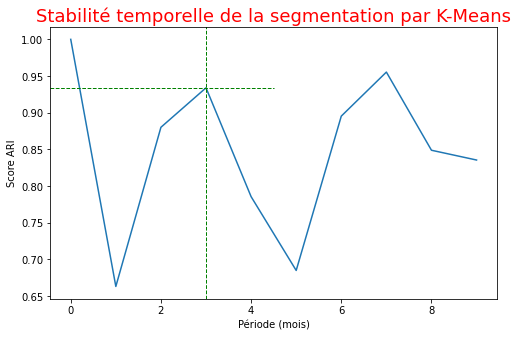

In [10]:
fig = plt.figure(figsize=(8,5))
sns.lineplot(data=df_ari, x="Month", y="ari_score")
plt.axhline(y=df_ari.iloc[2][1], linestyle="--", 
            color="green",
            xmax=0.5,
            linewidth=1)
plt.axvline(x=df_ari.iloc[2][0], linestyle="--", 
            color="green",
            ymax=4-(df_ari.iloc[2][1]),
            linewidth=1)
plt.xlabel("Période (mois)")
plt.ylabel("Score ARI")
plt.title("Stabilité temporelle de la segmentation par K-Means",
          fontsize=18,
          color="r")
plt.show()

## Conclusion 
- Le  plot des scores ARI obtenus sur les itérations par période de chaque moi, on remarque une forte inflexion après 3 mois sur les clients initiaux.
- Les client changeraient des clusters tous les 3 mois.